In [1]:
import os
import json
import random
import torch
import torchaudio
import pandas as pd
from pathlib import Path
import sys
import torchaudio.transforms as T
import torchaudio.prototype.transforms as PT
import matplotlib.pyplot as plt
# Add the parent directory of 'notebooks' to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # Move one level up
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from datagen.chordgen import __generate_midi_chord as generate_midi_chord, __synthesize_to_wav as synthesize_to_wav, __note_lookup as note_lookup, CHORDS, INVERSIONS, GM_INSTRUMENTS, JSON_FILE
from datagen.fxgen_torch import TorchFXGenerator
from datagen.pedals import Distortion, Chorus, Delay, Reverb, Noise, Normalizer
from utils.gdrive import download_from_gdrive

/Users/emortime/miniconda3/envs/fx_env/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [52]:
# Define dataset characteristics
TRAIN_SIZE = 2500
VAL_SIZE = 500 #deprecated
TEST_SIZE = 1000 #I think this is arbitrary now, deprecated - test size will generate automatically
BASE_PATH = Path("./timbral_bias_datasets")
SF2_SUBDIR = "sf2"
WAV_SUBDIR = "wav"
SF2_ARCHIVE = "FluidR3_GM.sf2"
SF2_DIR = Path(BASE_PATH, SF2_SUBDIR)

In [53]:
CHORDS = {
    "1": [0],
    "5": [0, 7],
    "maj": [0, 4, 7],
    "maj/2": [0, 4, 7, -10],
    "maj/4": [0, 4, 7, -7],
    "maj(9)": [0, 4, 7, 14],
    "min": [0, 3, 7],
    "min/2": [0, -9, 7],
    "min/4": [0, 3, -5],
    "min(9)": [0, 3, 7, 14],
    "dim": [0, 3, 6],
    "aug": [0, 4, 8],
    "sus2": [0, 2, 7],
    "sus4": [0, 5, 7],
    "sus4(b7)": [0, 5, 7, 10],
    "sus4(9)": [0, 5, 7, 14],
    "sus4(b7,9)": [0, 5, 7, 10, 14],
    "maj6": [0, 4, 7, 9],
    "maj6(9)": [0, 4, 7, 9, 14],
    "maj7": [0, 4, 7, 11],
    "min6": [0, 3, 7, 9],
    "min7": [0, 3, 7, 10],
    "minmaj7": [0, 3, 7, 11],
    "7": [0, 4, 7, 10],
    "hdim7": [0, 3, 6, 10],
    "dim7": [0, 3, 6, 9],
    "maj9": [0, 4, 7, 11, 14],
    "min9": [0, 3, 7, 10, 14],
    "9": [0, 4, 7, 10, 14],
    "7(#9)": [0, 4, 7, 10, 15],
    "11": [0, 4, 7, 10, 14, 17],
    "min11": [0, 3, 7, 10, 14, 17],
    "13": [0, 4, 7, 10, 14, 17, 21],
}

INVERSIONS = {
    "maj/3": [0, -8, 7],
    "maj/5": [0, 4, -5],
    "min/b3": [0, -9, 7],
    "min/5": [0, 3, -5],
    "maj7/3": [0, -8, 7, 11],
    "maj7/5": [0, 4, -5, 11],
    "maj7/7": [0, 4, 7, -1],
    "min7/b3": [0, -9, 7, 10],
    "min7/5": [0, 3, -5, 10],
    "min7/b7": [0, 3, 7, -2],
    "7/3": [0, -8, 7, 10],
    "7/5": [0, 4, -5, 10],
    "7/b7": [0, 4, 7, -2]
}

INVERSIONS = {} #did we remove these?

# Combined valid chord definitions (union of CHORDS and INVERSIONS)
VALID_CHORDS = set(CHORDS.keys()).union(INVERSIONS.keys())

# Validate genre lists
def validate_chords(genre_list):
    # Ensure only valid chords from the genre list are retained
    return [chord for chord in genre_list if chord in VALID_CHORDS]

# Updated genre lists
METAL_PRIMARY = validate_chords(["1", "5", "sus4", "sus4(b7)", "min", "dim"])
METAL_SECONDARY = validate_chords(["maj", "min7", "7", "aug", "7/3", "7/5", "min/5", "min/b3"])

POP_PRIMARY = validate_chords(["maj", "min", "sus2", "sus4", "maj6", "7", "maj/2", "maj/4", "min/2", "min/4", "min/5", "maj/5", "maj/3"])
POP_SECONDARY = validate_chords(["maj7", "min7", "maj(9)", "min(9)", "7/b7"])

JAZZ_PRIMARY = validate_chords([
    "maj7", "min7", "maj9", "min9", "11", "13", "maj6(9)", "minmaj7", "hdim7", "dim7",
    "maj7/3", "maj7/5", "min7/5", "min7/b3", "7/5"
])
JAZZ_SECONDARY = validate_chords(["7(#9)", "sus4(b7,9)", "aug", "min11", "min7/b7", "maj7/7", "7/3", "min/5"])


# Secondary chords (lower probability but ensures representation)
METAL_SECONDARY = list(set(CHORDS.keys()) - set(METAL_PRIMARY))
POP_SECONDARY = list(set(CHORDS.keys()) - set(POP_PRIMARY))
JAZZ_SECONDARY = list(set(CHORDS.keys()) - set(JAZZ_PRIMARY))

In [54]:
def setup_soundfonts(base_path: Path):
    """
    Download and set up soundfonts if not already present.
    Returns path to the base directory containing sf2 folder.
    """
    # Move sf2 directory to base level, not within temp
    sf2_dir = base_path.parent / SF2_SUBDIR  # Move up one level from dataset dir
    sf2_dir.mkdir(parents=True, exist_ok=True)
    sf_filepath = sf2_dir / SF2_ARCHIVE
    
    if not sf_filepath.exists():
        print(f"Downloading soundfont to {sf_filepath}")
        download_from_gdrive(SF2_ARCHIVE, str(sf_filepath.absolute()))
    else:
        print("Soundfont already exists, skipping download")
    
    return sf_filepath.parent  # Return the directory containing sf2 folder

def select_chords_for_genre(primary_chords, secondary_chords, primary_weight=0.8, count=100):
    """
    Select chords for a genre with weighted probability.
    
    Args:
        primary_chords: List of primary chords for the genre
        secondary_chords: List of secondary chords for the genre
        primary_weight: Probability weight for primary chords
        count: Number of chords to select
    """
    primary_count = int(count * primary_weight)
    secondary_count = count - primary_count
    
    selections = (
        random.choices(primary_chords, k=primary_count) +
        random.choices(secondary_chords, k=secondary_count)
    )
    return selections

In [55]:
# Define genre-appropriate instruments
METAL_INSTRUMENTS = {
    29: "overdriven_guitar",
    30: "distortion_guitar",
    27: "electric_guitar_(clean)"  # For some variety
}

POP_INSTRUMENTS = {
    80: "lead_1_(square)",
    81: "lead_2_(sawtooth)", 
    4: "electric_piano_1",
    5: "electric_piano_2",
    27: "electric_guitar_(clean)"
}

JAZZ_INSTRUMENTS = {
    0: "acoustic_grand_piano",
    24: "acoustic_guitar_(nylon)",
    26: "electric_guitar_(jazz)",
    4: "electric_piano_1"
}

# FX combinations remain the same
METAL_FX = {
    'distortion': ['classic_distortion', 'fuzz'],
    'noise': ['room_noise'],
    'reverb': ['small_room']
}

POP_FX = {
    'reverb': ['plate', 'large_hall'],
    'chorus': ['subtle', 'classic'],
    'distortion': ['subtle_drive']
}

JAZZ_FX = {
    'reverb': ['large_hall', 'plate'],
    'chorus': ['subtle'],
    'delay': ['subtle']
}

In [56]:
def normalize_batch(batch: torch.Tensor, target_db: float = -1.0) -> torch.Tensor:
        """Normalize a batch of audio to target dB level."""
        max_val = torch.max(torch.abs(batch))
        target_val = 10 ** (target_db / 20)
        
        if max_val > target_val:
            batch = batch * (target_val / max_val)
            
        return batch

def convert_to_mp3(wav_path: Path, target_path: Path, sample_rate: int = 44100, bitrate: float = 192.0):
    """
    Convert WAV file to MP3 using torchaudio.
    
    Args:
        wav_path: Path to source WAV file
        target_path: Path to output MP3 file
        sample_rate: Target sample rate
        bitrate: Target bitrate in kbps
    """
    waveform, sr = torchaudio.load(str(wav_path))
    
    # Convert to mono if stereo
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Ensure correct sample rate
    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)
    
    # Save as MP3
    torchaudio.save(
        str(target_path),
        waveform,
        sample_rate,
        format="mp3",
        compression=bitrate/1000  # torchaudio expects compression rate in kbps/1000
    )

def batch_convert_wavs_to_mp3(wav_dir: Path, mp3_dir: Path):
    """
    Convert all WAV files in a directory to MP3.
    Updates metadata to reflect MP3 filenames.
    
    Args:
        wav_dir: Directory containing WAV files
        mp3_dir: Directory to save MP3 files
    """
    mp3_dir.mkdir(exist_ok=True)
    
    # Load metadata
    json_path = wav_dir.parent / JSON_FILE
    with open(json_path, 'r') as f:
        metadata = json.load(f)
    
    # Convert each file and update metadata
    updated_metadata = {}
    for wav_file in wav_dir.glob("*.wav"):
        mp3_file = mp3_dir / wav_file.with_suffix('.mp3').name
        convert_to_mp3(wav_file, mp3_file)
        
        # Update metadata
        base_name = wav_file.stem
        if base_name in metadata:
            entry = metadata[base_name].copy()
            entry['filename'] = mp3_file.name
            entry['format'] = 'mp3'
            updated_metadata[base_name] = entry
    
    # Save updated metadata
    with open(mp3_dir.parent / JSON_FILE, 'w') as f:
        json.dump(updated_metadata, f)
    
    return updated_metadata

In [57]:
def __save_json(data: dict, path: Path):
    """Save metadata in the same format as chordgen."""
    dumps = json.dumps(data)
    os.makedirs(path, exist_ok=True)
    with open(path / JSON_FILE, 'w') as outfile:
        outfile.write(dumps)

def generate_chord_samples(output_path: Path, chord_list: list, instruments: dict, 
                         sample_count: int, duration: float = 2.0):
    """
    Generate specific chord samples with selected instruments.
    
    Args:
        output_path: Directory to save generated files
        chord_list: List of chord types to generate
        instruments: Dictionary of GM preset IDs and names to use
        sample_count: Number of samples to generate
        duration: Length of audio samples in seconds
    
    Returns:
        Dictionary of metadata matching chordgen's format
    """
    temp_path = output_path / "temp"
    wav_dir = temp_path / "wav"
    #sf2_dir = temp_path / "sf2"
    wav_dir.mkdir(parents=True, exist_ok=True)
    #sf2_dir.mkdir(parents=True, exist_ok=True)
    
    # Calculate samples per chord to meet target count
    samples_per_chord = max(1, sample_count // len(chord_list))
    
    json_out = {}
    sf_filepath = SF2_DIR / "FluidR3_GM.sf2"
    
    # Generate each chord with selected instruments
    for chord_type in chord_list:
        # Select random root notes for variety  
        root_notes = random.choices(range(12), k=samples_per_chord)  # 0-11 for C through B
        octaves = random.choices(range(3, 5), k=samples_per_chord)  # Octaves 3-4
        
        for root, octave in zip(root_notes, octaves):
            # Generate MIDI data
            midi = generate_midi_chord(root + (octave * 12), CHORDS[chord_type])
            note_name = note_lookup(root + (octave * 12))
            
            # Save MIDI file
            mid_filename = f"{note_name}{chord_type.replace('/','inv')}_O{octave}"
            mid_filepath = wav_dir / f"{mid_filename}.mid"
            midi.save(mid_filepath)
            
            # Generate audio for each selected instrument
            selected_instruments = random.sample(list(instruments.items()), 
                                              k=min(2, len(instruments)))  # Select 1-2 instruments
            
            for preset_id, instrument_name in selected_instruments:
                wav_filename = f"{mid_filename}_{instrument_name}"
                wav_filepath = wav_dir / f"{wav_filename}.wav"

                reduction = 4.5 if preset_id == 30 else (1 if preset_id == 29 else .1)
                
                # Synthesize audio
                synthesize_to_wav(
                    str(mid_filepath.absolute()),
                    str(sf_filepath.absolute()),
                    str(wav_filepath.absolute()),
                    preset_id=preset_id,
                    seconds_to_generate=duration,
                    gain=reduction #this is flipped for some reason so 1=-1
                )
                
                # Create metadata entry matching chordgen's format
                json_out[wav_filename] = {
                    "root": note_name,
                    "chord_class": chord_type,
                    "billboard_notation": f"{note_name}:{chord_type}",
                    "octave": octave,
                    "instrument": instrument_name,
                    "gm_preset_id": preset_id,
                    "filename": f"{wav_filename}.wav",
                    "format": "wav",
                    "duration(s)": duration,
                    "sample_rate": 44100,
                    "bit_depth": 16
                }
            
            # Clean up MIDI file after generating all instrument versions
            os.remove(mid_filepath)
    
    # Save metadata in chord_ref.json
    __save_json(json_out, temp_path)
    
    #return json_out

    # After generating all WAVs and metadata
    wav_dir = temp_path / "wav"
    mp3_dir = temp_path / "mp3"
    
    # Convert WAVs to MP3s and update metadata
    json_out = batch_convert_wavs_to_mp3(wav_dir, mp3_dir)
    
    # Clean up WAV files if desired
    for wav_file in wav_dir.glob("*.wav"):
        wav_file.unlink()
    wav_dir.rmdir()
    
    return json_out

In [58]:
def process_audio_with_fx_chain(audio_path: Path, output_path: Path, fx_presets: dict):
    """
    Process an audio file with a specific chain of effects.
    
    Args:
        audio_path: Path to input audio file
        output_path: Path to save processed audio
        fx_presets: Dictionary of effects and their preset lists to apply
    """
    # Load audio
    waveform, sr = torchaudio.load(str(audio_path))
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    waveform = waveform.squeeze(0)  # Remove channel dimension

    #print(f"waveform: {waveform.shape}")

    audio = waveform.numpy()
    
    # Apply effects in sequence
    processed = audio
    applied_fx = {}
    
    # For each effect type, use the first preset in its list
    # This ensures consistent processing within each genre
    for fx_type, preset_list in fx_presets.items():
        preset_name = preset_list[0]  # Use first preset from list
        
        if fx_type == 'distortion':
            dist = Distortion.Distortion(sr=sr)
            preset_params = dist.get_presets()[preset_name]
            processed = dist.distort(processed, **preset_params)
        elif fx_type == 'reverb':
            rev = Reverb.Reverb(sr=sr)
            preset_params = rev.get_presets()[preset_name]
            processed = rev.reverb(processed, **preset_params)
        elif fx_type == 'chorus':
            cho = Chorus.Chorus(sr=sr)
            preset_params = cho.get_presets()[preset_name]
            processed = cho.process(processed, **preset_params)
        elif fx_type == 'noise':
            noise = Noise.NoiseGenerator(sr=sr)
            preset_params = noise.get_presets()[preset_name]
            processed = noise.add_noise(processed, **preset_params)
        
        processed = Normalizer.limit_audio(processed, threshold_db=-1.0)
            
        applied_fx[fx_type] = preset_name
    
    processed_tensor = torch.from_numpy(processed).type(torch.float32)  # Explicitly set to float32
    
    # Save processed audio
    # Generate a string summarizing the applied effects
    fx_summary = "_".join(f"{fx}_{preset}" for fx, preset in applied_fx.items())
    torchaudio.save(
        str(output_path) + fx_summary + ".mp3",
        processed_tensor.unsqueeze(0),  # Add back channel dimension
        sr,
        format="mp3",
        compression=192
    )
    
    return applied_fx

def generate_biased_dataset(output_path: Path, size: int, genre_weights=(0.33, 0.33, 0.34)):
    """
    Generate a dataset with intentional genre-based timbral bias.
    """
    output_path.mkdir(parents=True, exist_ok=True)
    processed_dir = output_path / f"processed"
    processed_dir.mkdir(exist_ok=True)

    # Define temporary directories
    temp_dir = output_path / f"temp"
    mp3_dir = temp_dir / f"mp3"
    wav_dir = temp_dir / f"wav"
    #sf2_dir = temp_dir / "sf2"
    sf2_dir = SF2_DIR
    mp3_dir.mkdir(parents=True, exist_ok=True)
    wav_dir.mkdir(parents=True, exist_ok=True)
    #sf2_dir.mkdir(parents=True, exist_ok=True)

    # Calculate genre-specific sample counts
    metal_count = int(size * genre_weights[0])
    pop_count = int(size * genre_weights[1])
    jazz_count = size - metal_count - pop_count

    all_samples = []

    # Generate samples for each genre using predefined FX configurations
    for genre_idx, (primary_chords, secondary_chords, instruments, count, fx_chain) in enumerate([
        (METAL_PRIMARY, METAL_SECONDARY, METAL_INSTRUMENTS, metal_count, METAL_FX),
        (POP_PRIMARY, POP_SECONDARY, POP_INSTRUMENTS, pop_count, POP_FX),
        (JAZZ_PRIMARY, JAZZ_SECONDARY, JAZZ_INSTRUMENTS, jazz_count, JAZZ_FX)
    ]):
        print(f"Processing {['metal', 'pop', 'jazz'][genre_idx]} samples...")

        # Select chords for this genre
        selected_chords = select_chords_for_genre(primary_chords, secondary_chords, count=count)

        # Generate samples
        genre_metadata = generate_chord_samples(
            output_path=output_path,
            chord_list=selected_chords,
            instruments=instruments,
            sample_count=count
        )

        # Process each sample with the genre-specific FX chain
        for filename, metadata in genre_metadata.items():
            input_path = mp3_dir / f"{filename}.mp3"  # Use mp3_dir for input path
            output_file = processed_dir / f"proc_{filename}"  # Separate processed output path

            # Apply FX chain
            applied_fx = process_audio_with_fx_chain(input_path, output_file, fx_chain)            

            # Update metadata
            metadata.update({
                'genre': ['metal', 'pop', 'jazz'][genre_idx],
                'applied_fx': applied_fx,
                'processed_path': str(output_file)
            })
            all_samples.append(metadata)

    # Save complete dataset metadata
    with open(output_path / "fx_chord_ref.json", 'w') as f:
        json.dump(all_samples, f, indent=4)

    

In [59]:
from itertools import product

def generate_balanced_test_set(output_path: Path, size: int):
    """
    Generate balanced test set with all combinations of instruments, effects,
    and chords across genres, ensuring comprehensive coverage.

    Args:
        output_path: Directory to save generated files
        size: Target size of the test set (ensures coverage of all combinations)
    """
    output_path.mkdir(parents=True, exist_ok=True)

    processed_dir = output_path / "processed"
    processed_dir.mkdir(exist_ok=True)

    temp_dir = output_path / "temp"
    mp3_dir = temp_dir / "mp3"
    mp3_dir.mkdir(parents=True, exist_ok=True)
    
    # Union of all instruments and effects
    all_instruments = set()
    all_fx = set()

    for instruments, fx_presets in [
        (METAL_INSTRUMENTS, METAL_FX),
        (POP_INSTRUMENTS, POP_FX),
        (JAZZ_INSTRUMENTS, JAZZ_FX),
    ]:
        all_instruments.update(instruments.keys())
        all_fx.update(fx_presets.keys())

    # Generate all combinations of instruments and effects
    all_combinations = list(product(all_instruments, all_fx))

    print(f"Total combinations (instrument-effect): {len(all_combinations)}")
    
    # Get all unique chord types
    all_chords = set(METAL_PRIMARY + METAL_SECONDARY + POP_PRIMARY + POP_SECONDARY + JAZZ_PRIMARY + JAZZ_SECONDARY)

    all_samples = []

    # Iterate over all chords and all instrument-effect combinations
    for chord, (instrument, effect) in product(all_chords, all_combinations):
        # Select instrument preset and effect preset
        instrument_preset = {instrument: METAL_INSTRUMENTS.get(instrument) or POP_INSTRUMENTS.get(instrument) or JAZZ_INSTRUMENTS.get(instrument)}
        fx_preset = {effect: METAL_FX.get(effect) or POP_FX.get(effect) or JAZZ_FX.get(effect)}

        # Generate chord sample
        chord_samples = generate_chord_samples(
            output_path=output_path,
            chord_list=[chord],
            instruments=instrument_preset,
            sample_count=1
        )

        for filename, metadata in chord_samples.items():
            input_path = mp3_dir / f"{filename}.mp3"  # Use temp/mp3 directory
            output_file = processed_dir / f"proc_{filename}_{instrument}"  # Use processed directory

            applied_fx = process_audio_with_fx_chain(input_path, output_file, fx_preset)

            # Update metadata
            metadata.update({
                'chord': chord,
                'instrument': instrument,
                'effect': effect,
                'applied_fx': applied_fx,
                'processed_path': str(output_file)
            })
            all_samples.append(metadata)
        
        if len(all_samples) >= size:
            break

    # Save test set metadata
    with open(output_path / "test_metadata.json", 'w') as f:
        json.dump(all_samples, f, indent=2)

    print(f"Generated {len(all_samples)} samples for the balanced test set.")
    return len(all_samples)


In [60]:
# Generate datasets

# Training set with genre bias
generate_biased_dataset(
    BASE_PATH / "train",
    TRAIN_SIZE,
    genre_weights=(0.33, 0.34, 0.33)  # Slightly more metal to emphasize bias
)

# Balanced test set
#generate_balanced_test_set(
#    BASE_PATH / "test",
#    TEST_SIZE
#)

Processing metal samples...
Processing pop samples...


/Users/emortime/Documents/Masters/DL 7643/MLPD/amadeus-ex-machina/datagen/pedals/Reverb.py:93: RuntimeWarning: invalid value encountered in divide
  wet = wet / np.max(np.abs(wet))


Processing jazz samples...


In [99]:
#convert data to chroma/spectrograms
#this is functional but is more or less an example, use ChordDataProcessor (see below cells) for actual processing

def load_audio(audio_path: str):
    """Load an audio file and convert to mono if necessary."""
    waveform, sr = torchaudio.load(audio_path)
    if waveform.shape[0] > 1:  # If stereo, average channels to make mono
        waveform = waveform.mean(dim=0)
    return waveform, sr


def compute_spectrogram_torchaudio(waveform: torch.Tensor, n_fft: int = 2048, hop_length: int = 512):
    """Compute a spectrogram using torchaudio."""
    spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length, power=2.0)(waveform)
    return spectrogram


def compute_chromagram_torchaudio(waveform: torch.Tensor, sr: int, n_fft: int = 2048, hop_length: int = 512):
    """
    Compute a chromagram using torchaudio.prototype.transforms.ChromaSpectrogram.
    
    Args:
        waveform: The input audio waveform.
        sr: Sampling rate of the audio.
        n_fft: FFT size.
        hop_length: Hop length for STFT.
        
    Returns:
        chromagram: Chromagram tensor of shape (12, time).
    """
    chroma_transform = PT.ChromaSpectrogram(
        sample_rate=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_chroma=12,  # 12 pitch classes
    )
    chromagram = chroma_transform(waveform)
    return chromagram


def process_audio_to_features_torchaudio(audio_path: Path, output_dir: Path):
    """
    Process an MP3 file to compute and save its spectrogram and chromagram using torchaudio.

    Args:
        audio_path: Path to the input audio file (MP3).
        output_dir: Directory to save the processed features.
    """
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    waveform, sr = load_audio(audio_path)

    # Compute features
    spectrogram = compute_spectrogram_torchaudio(waveform)
    chromagram = compute_chromagram_torchaudio(waveform, sr)

    return spectrogram, chromagram


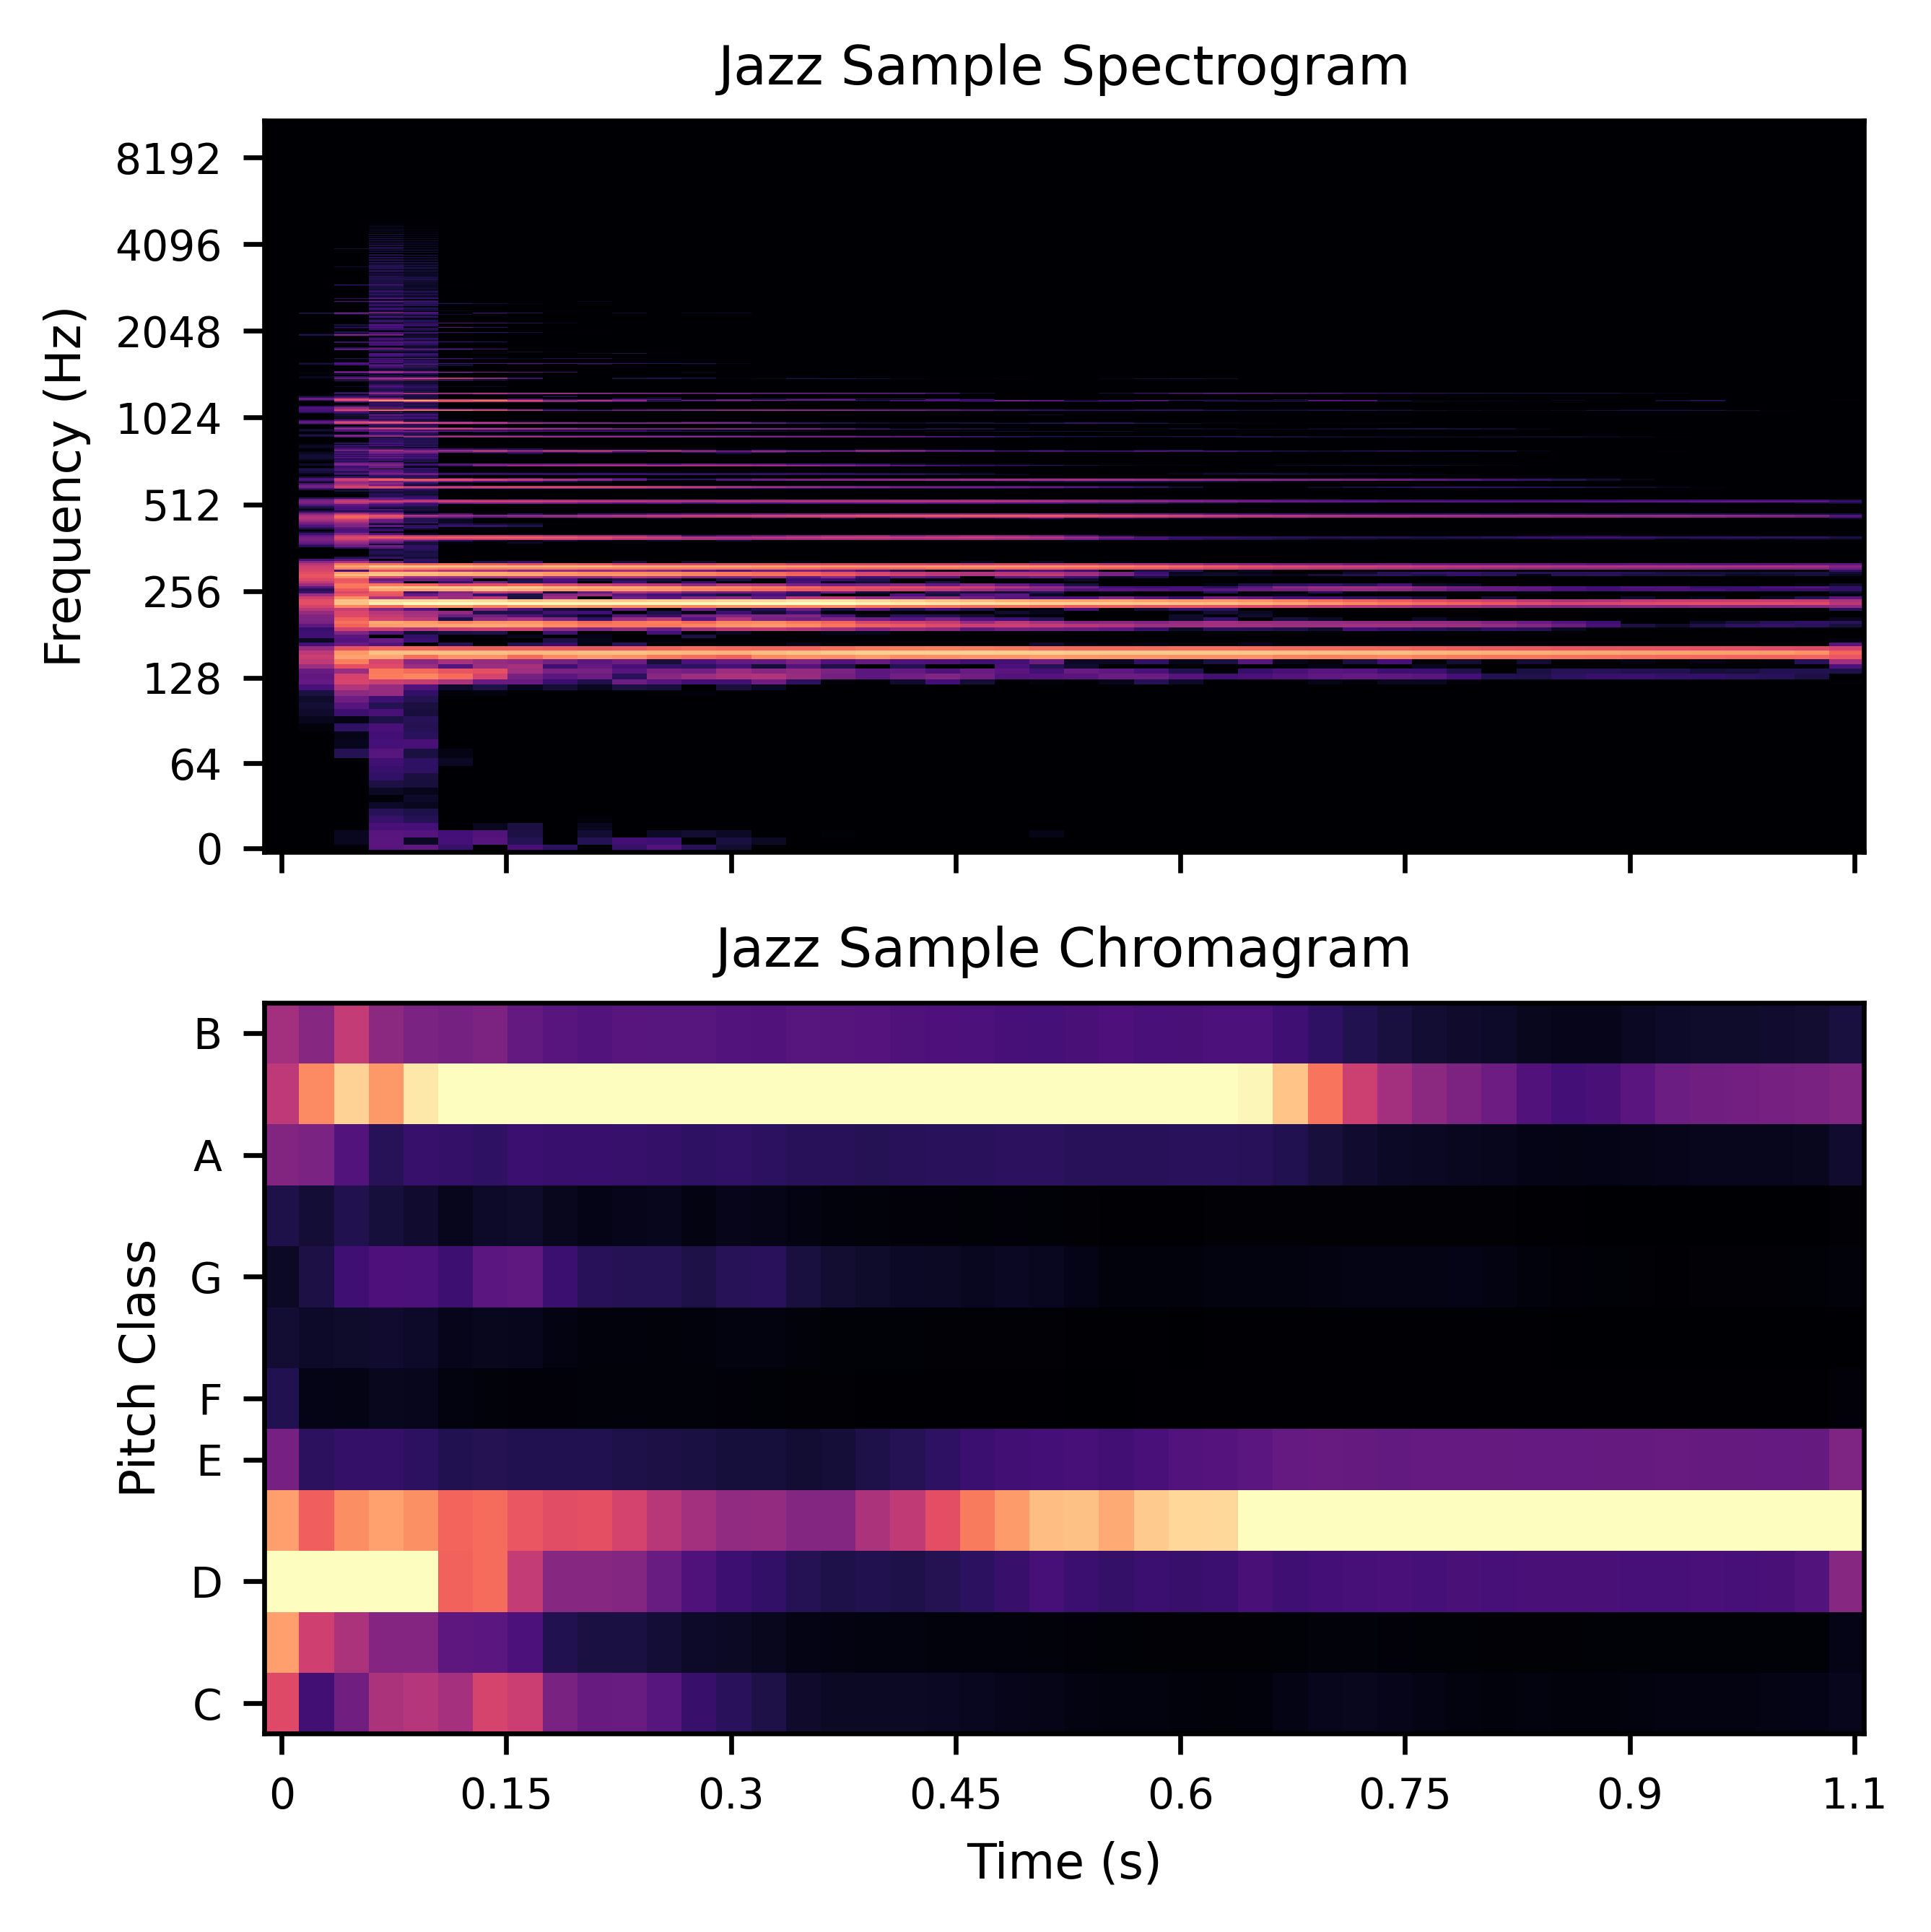

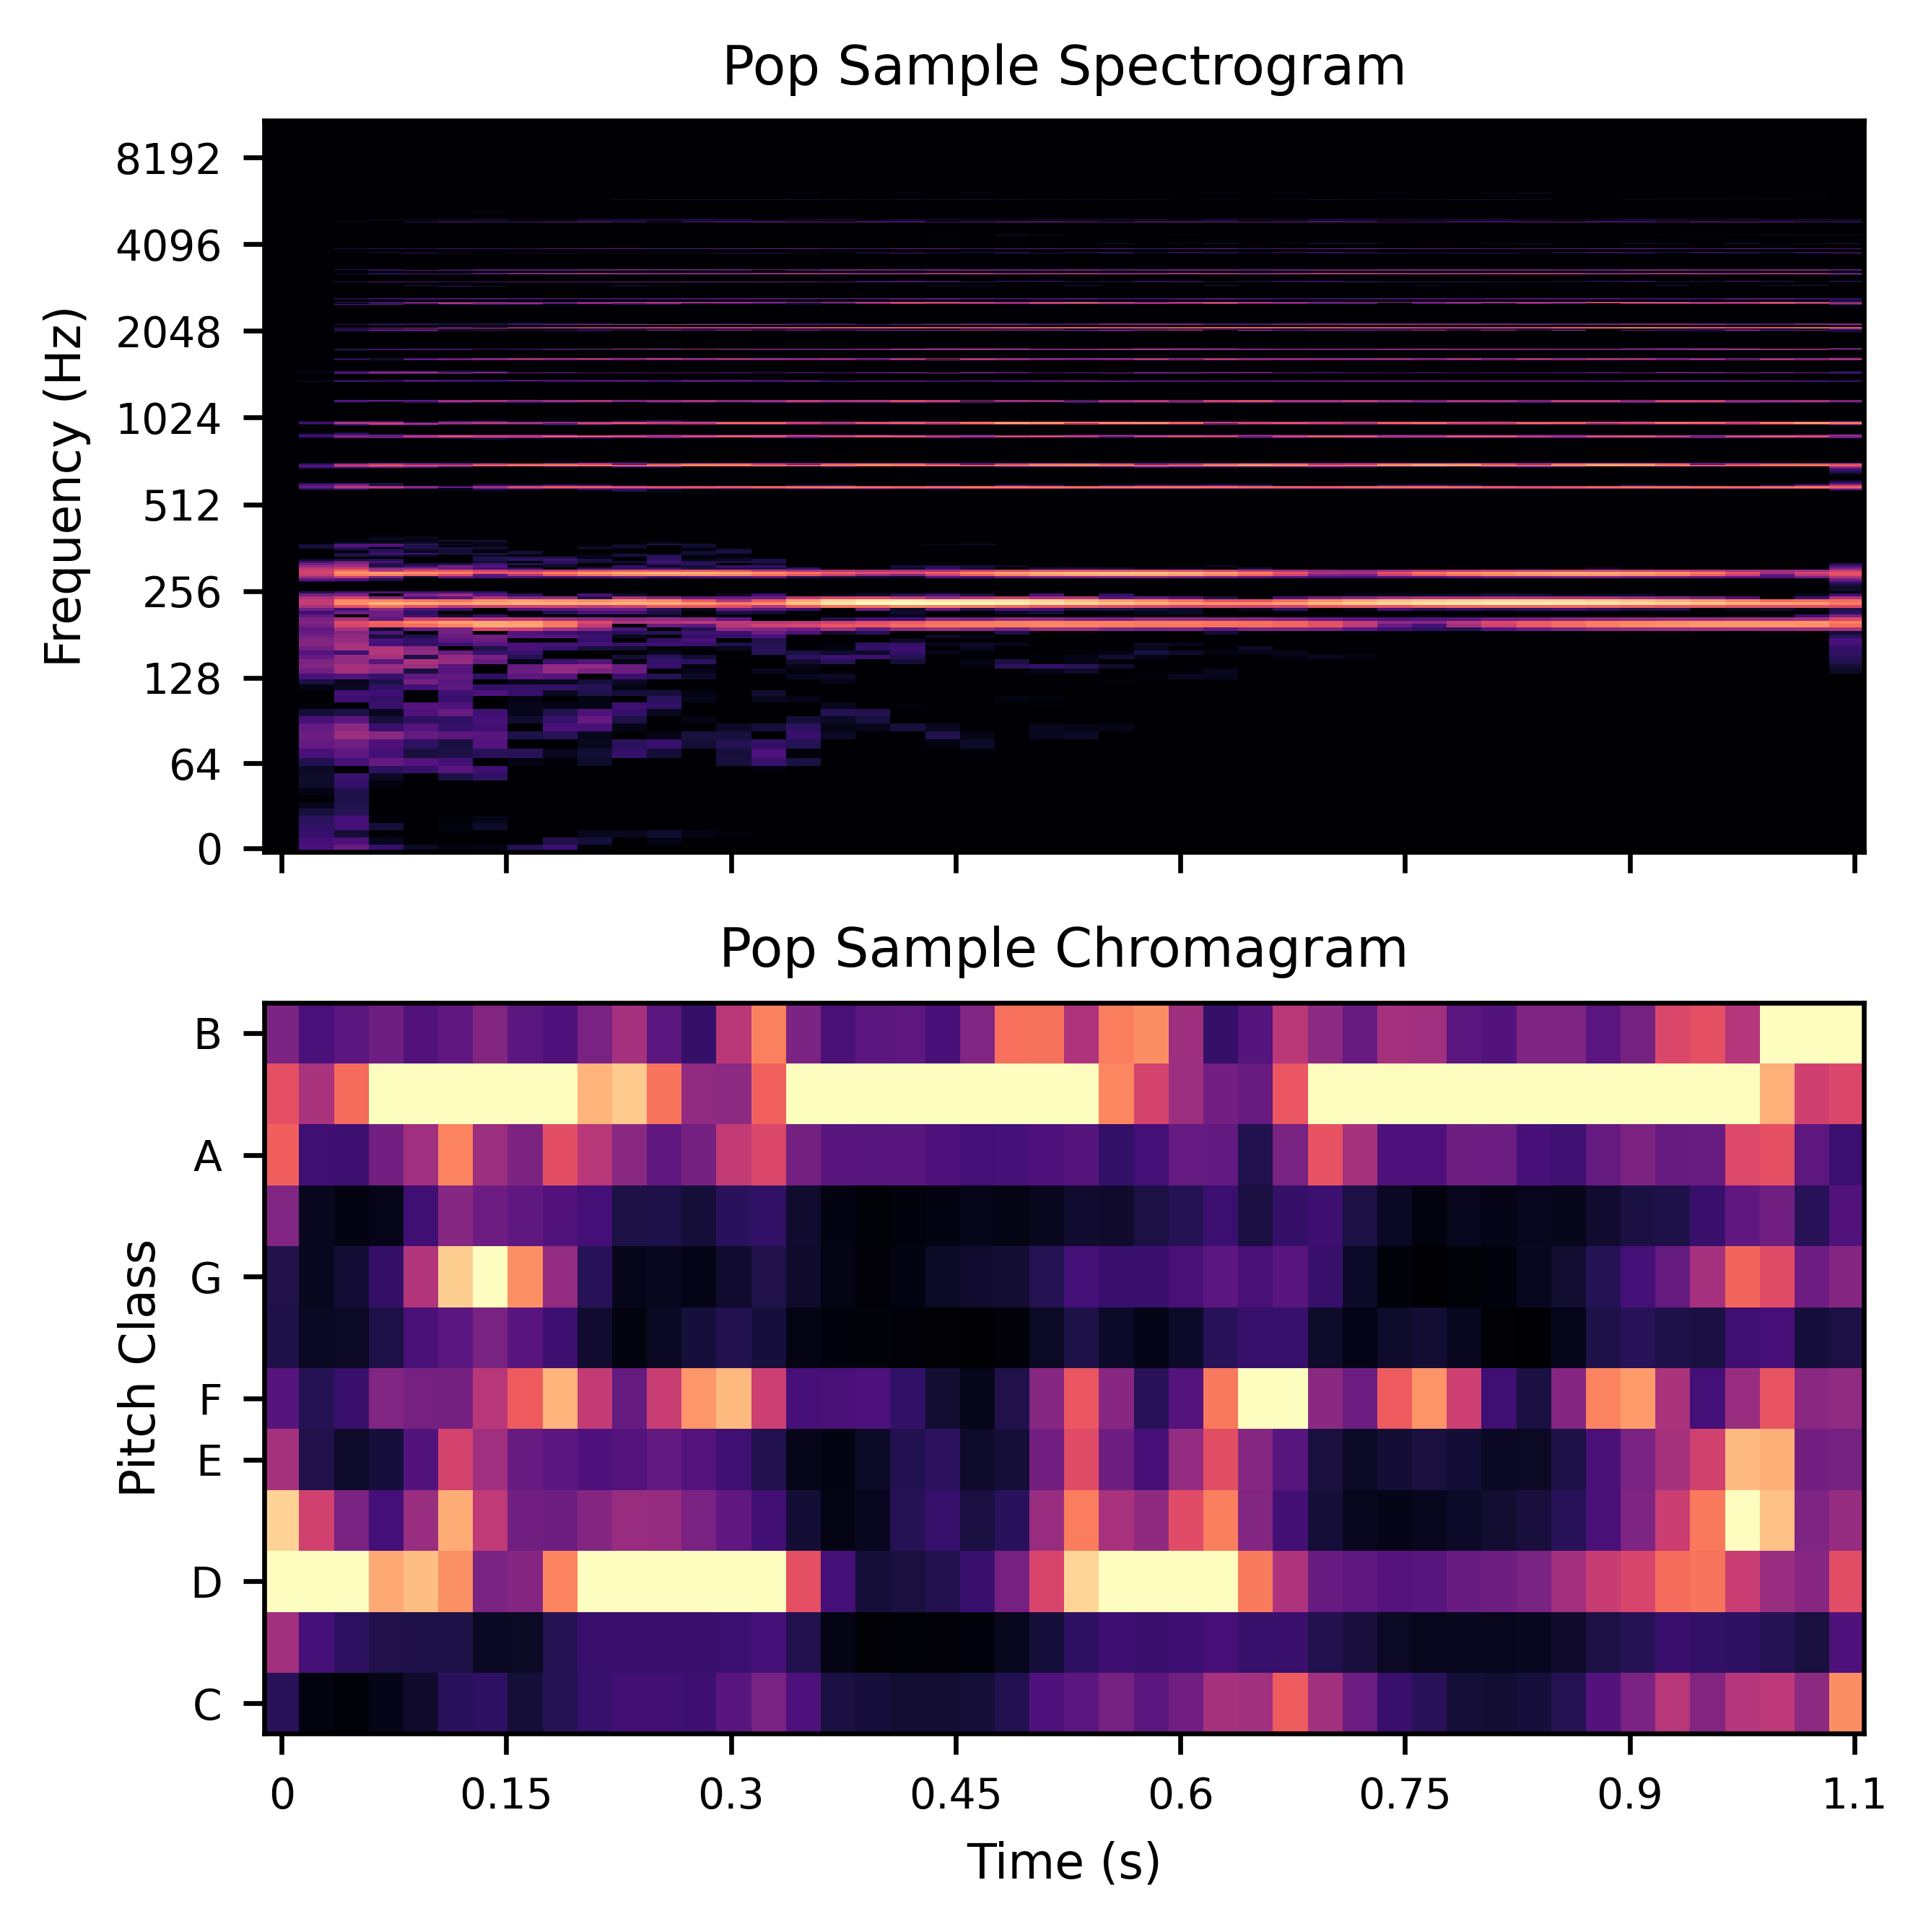

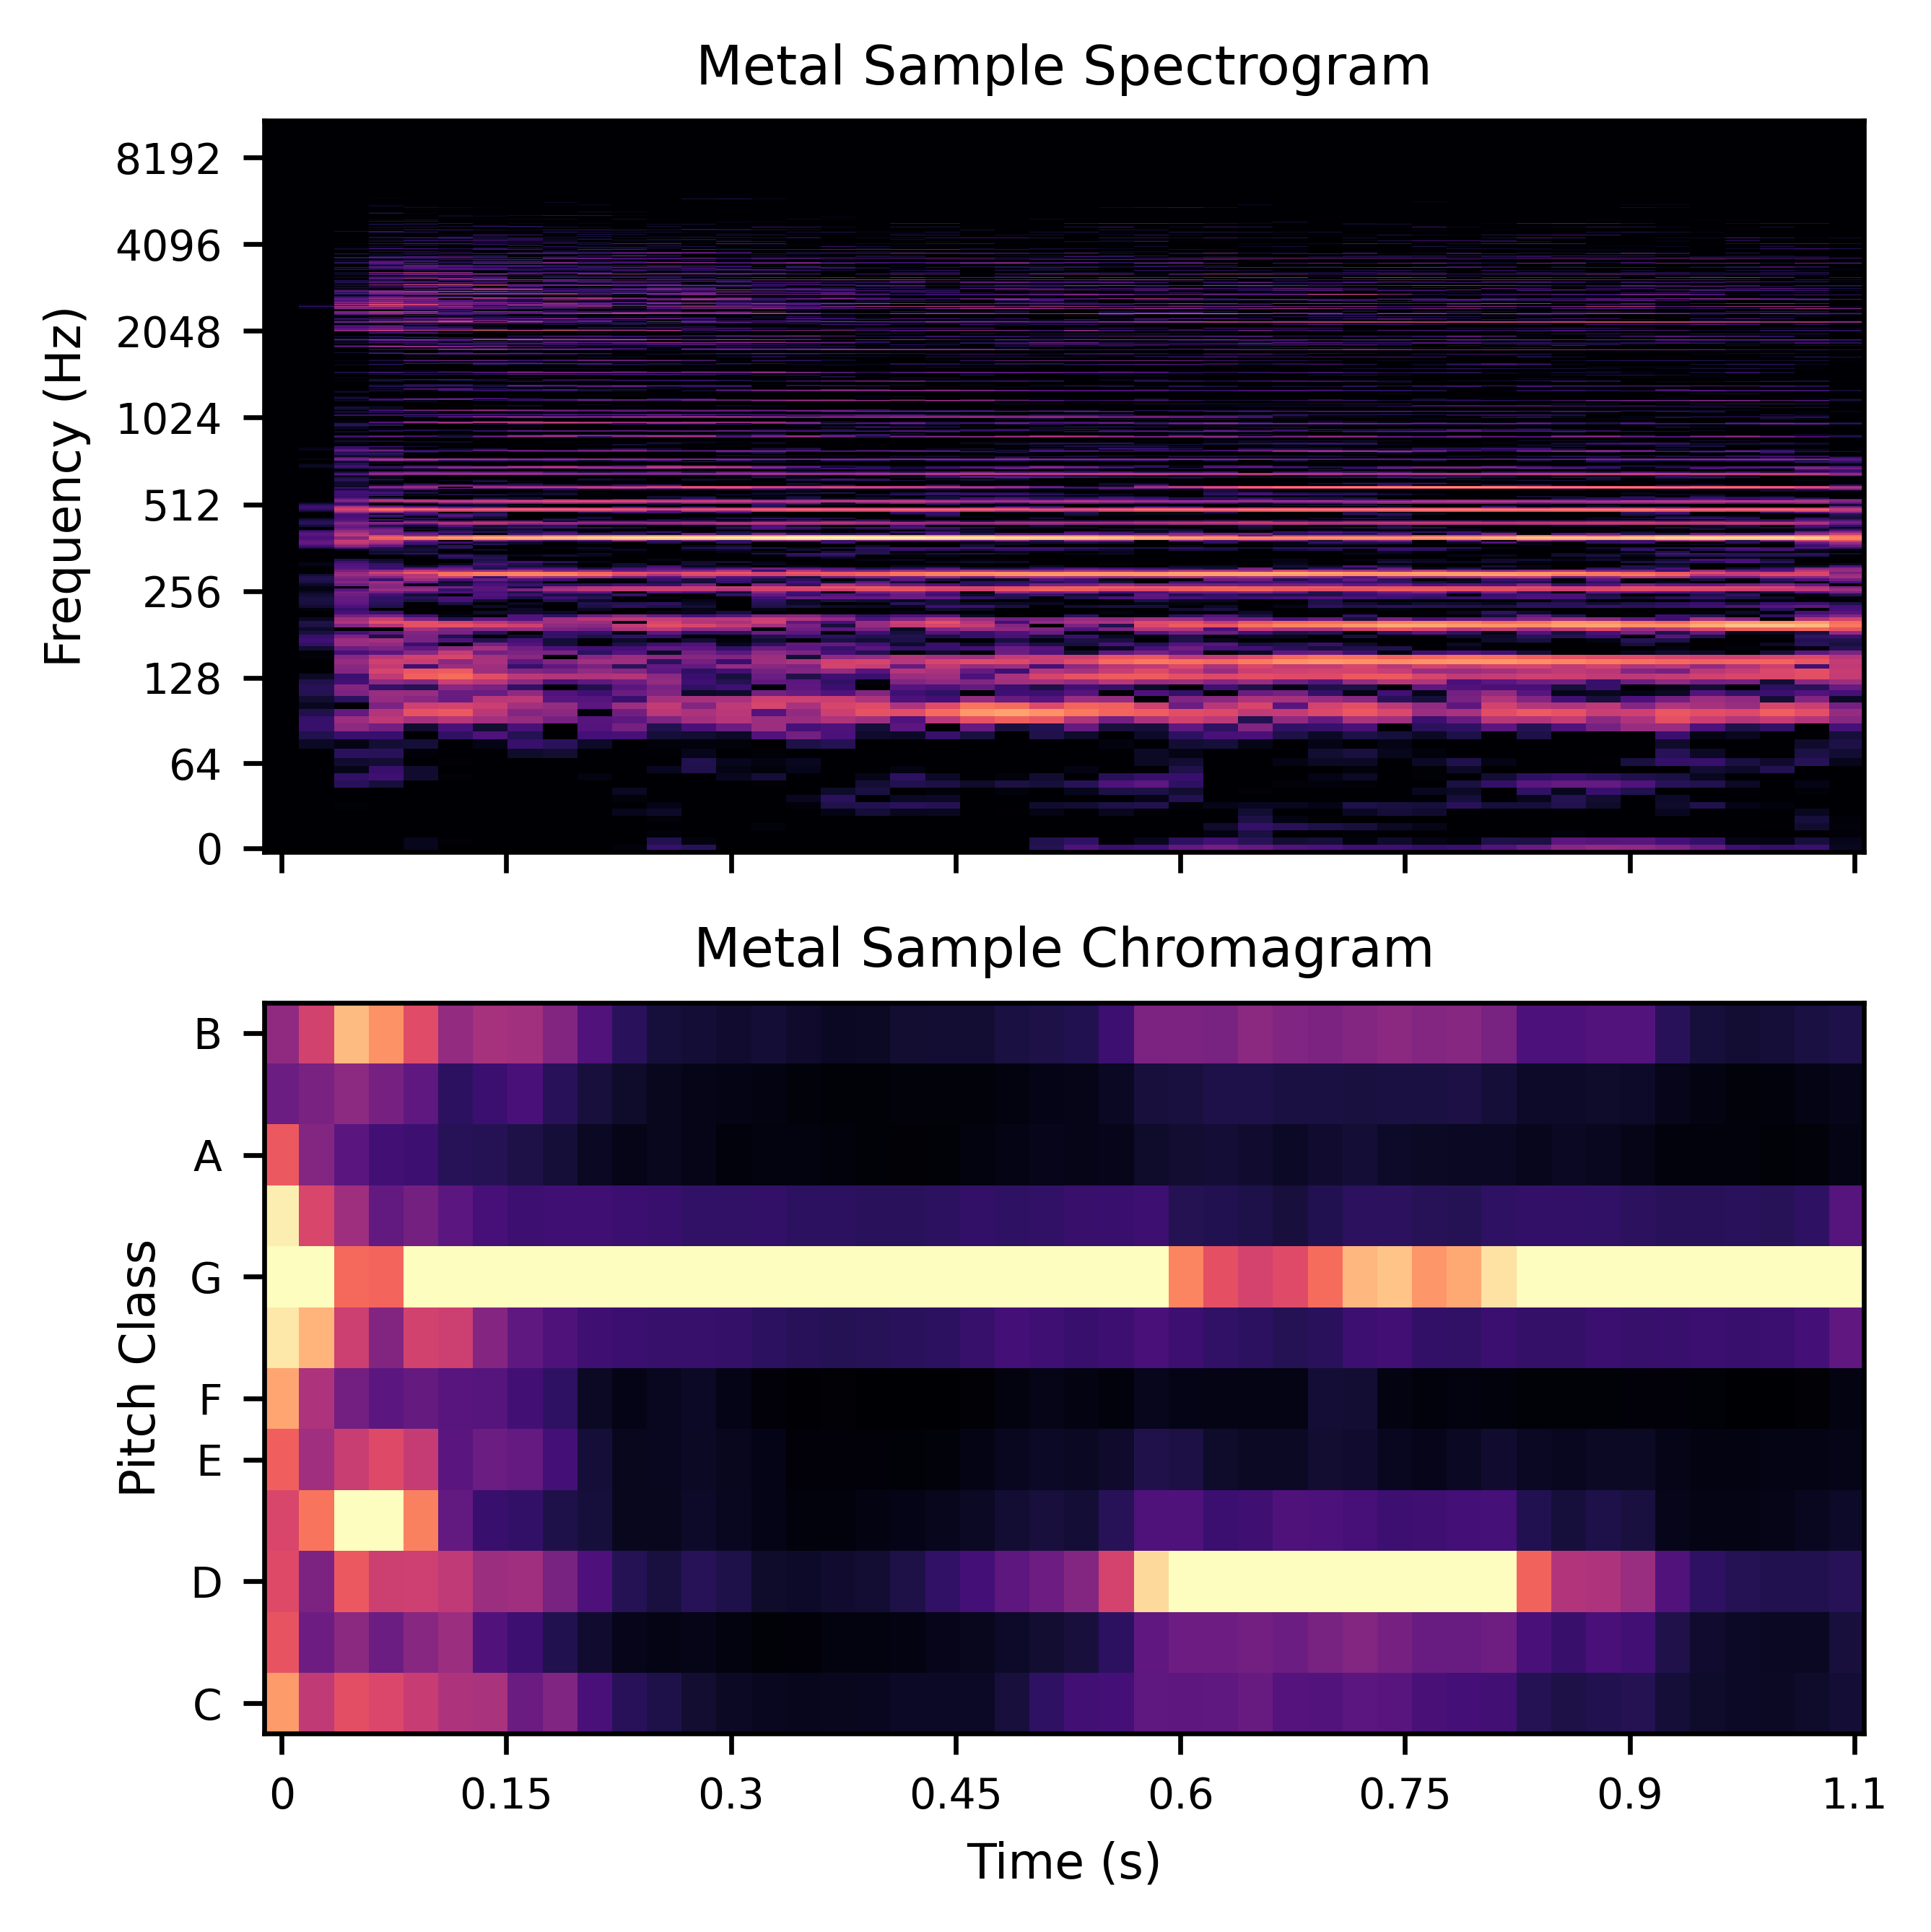

In [127]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Function to generate and save spectrogram and chromagram plots
def plot_spectrogram_chromagram(audio_file, title_prefix):
    y, sr = librosa.load(audio_file)

    # Compute the Short-Time Fourier Transform (STFT)
    S = np.abs(librosa.stft(y, n_fft=4096))**2

    # Compute the Chromagram
    chroma = librosa.feature.chroma_stft(S=S, sr=sr)

    # Create a plot with two subplots
    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(4.5, 4.5))  # Adjust for single-column format

    # Display the Spectrogram
    librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                             y_axis='log', x_axis='time', ax=ax[0])
    ax[0].set(title=f'{title_prefix} Spectrogram')
    ax[0].set_ylabel("Frequency (Hz)")
    ax[0].label_outer()

    # Display the Chromagram
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax[1])
    ax[1].set(title=f'{title_prefix} Chromagram')
    ax[1].set_ylabel("Pitch Class")
    ax[1].set_xlabel("Time (s)")

    # Tight layout for better spacing
    plt.tight_layout()

    # Save plot
    plt.savefig(f"{title_prefix.lower()}_plot.png", dpi=300, bbox_inches="tight")
    plt.show()


# Generate plots for each audio file
plot_spectrogram_chromagram('jazz.wav', 'Jazz Sample')
plot_spectrogram_chromagram('pop.wav', 'Pop Sample')
plot_spectrogram_chromagram('metal.wav', 'Metal Sample')


FileNotFoundError: [Errno 2] No such file or directory: '/Users/emortime/Documents/Masters/DL 7643/MLPD/amadeus-ex-machina/notebooks/texturebias_experiment/visualizations/test.wav_chromagram.png/Chromagram/Pitch Class.png'

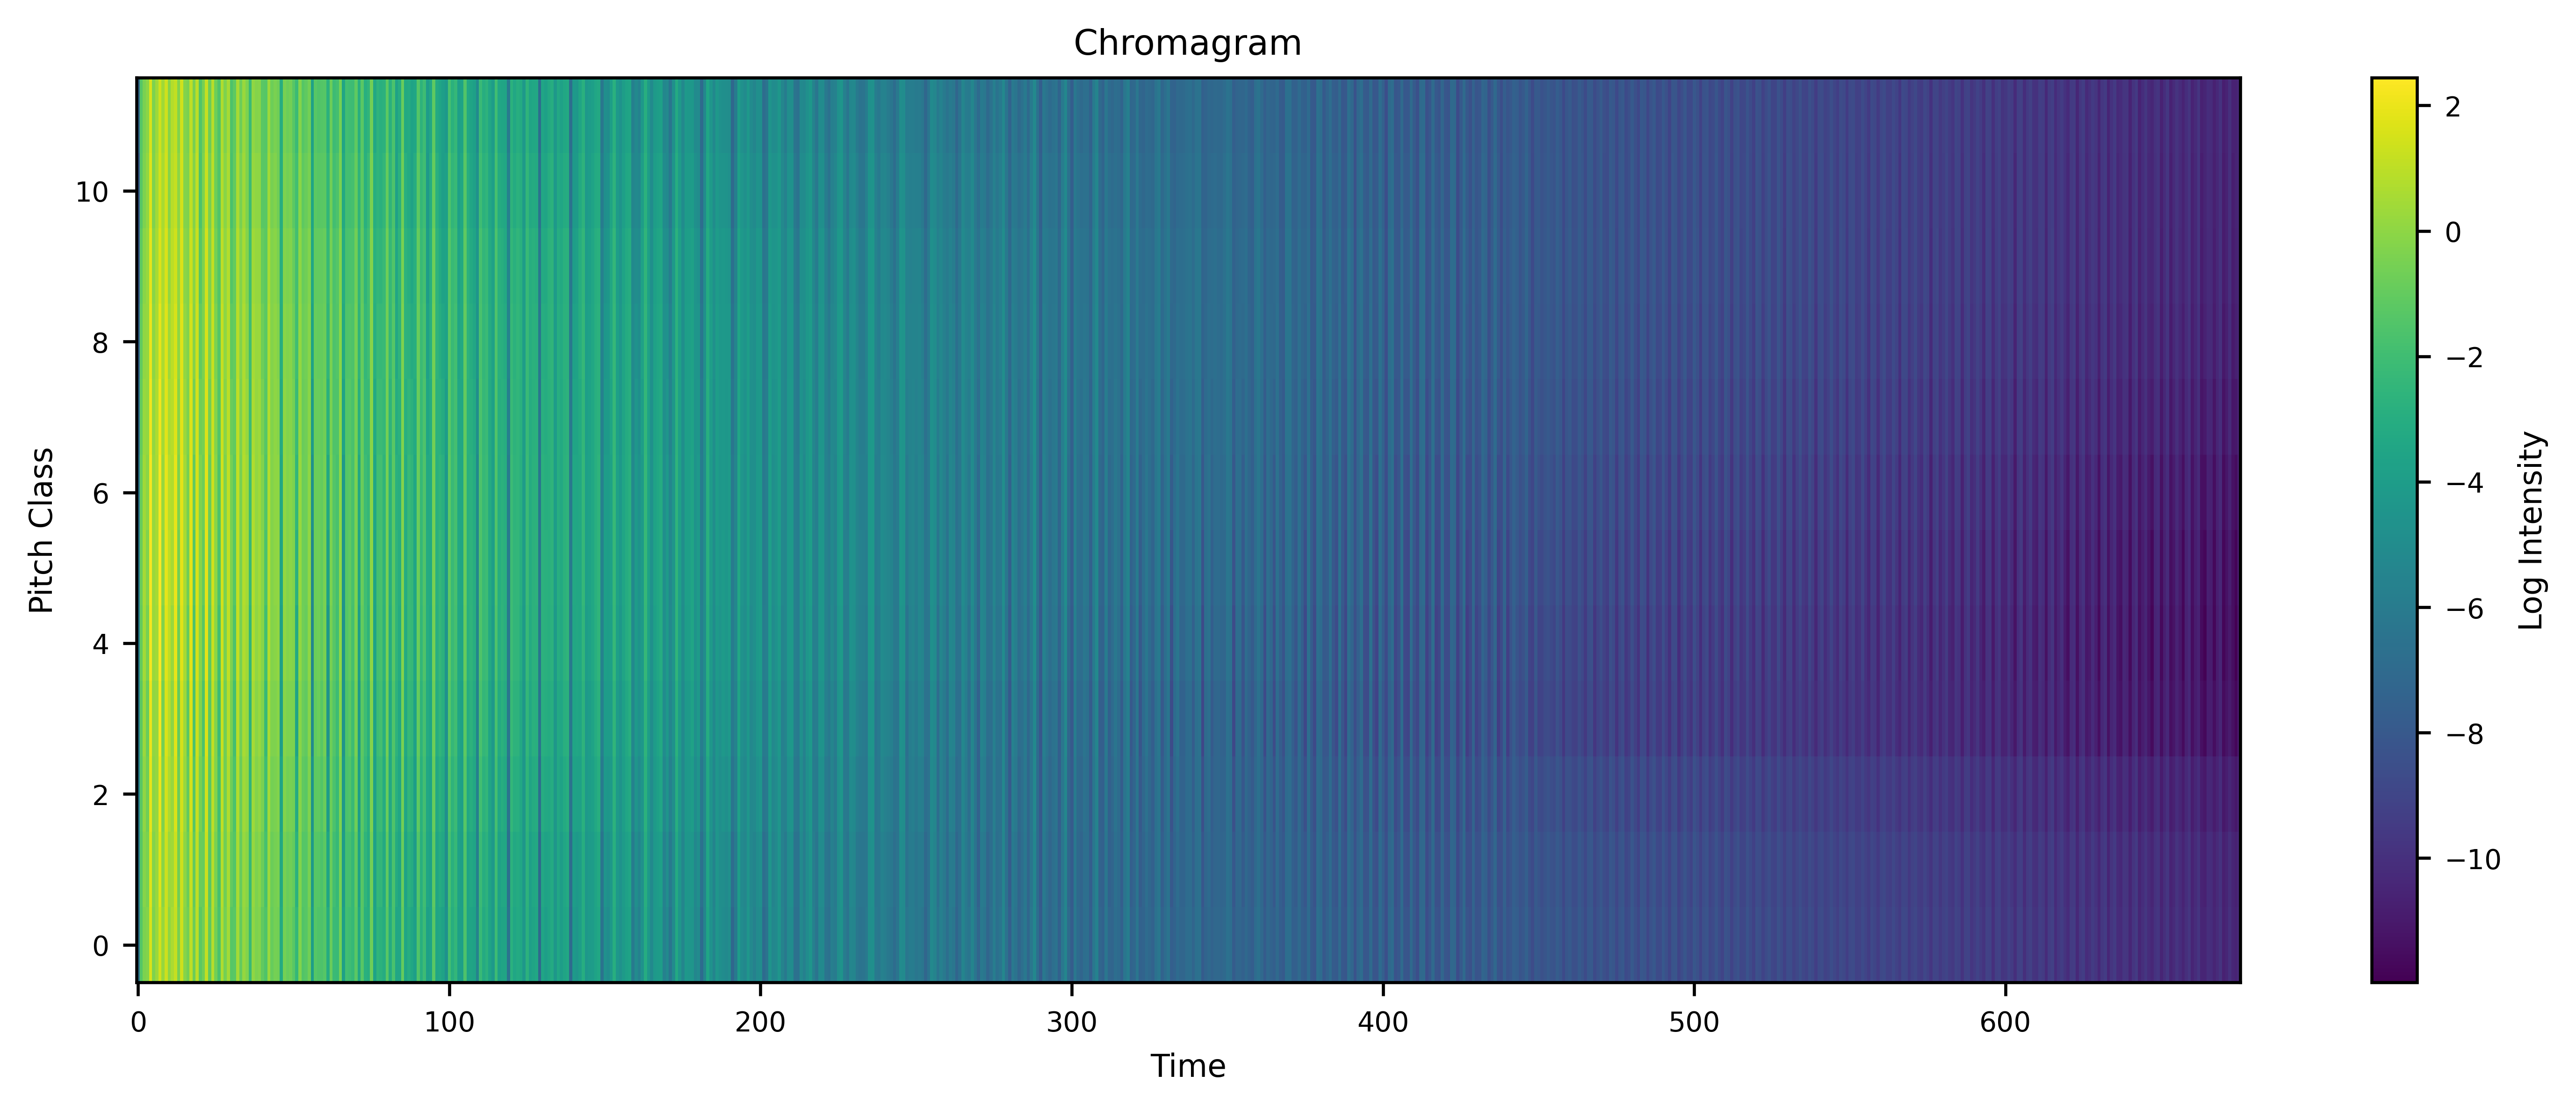

In [122]:
from torchaudio.prototype import transforms

def save_visualization(feature: torch.Tensor, output_path: Path, title: str, ylabel: str, cmap: str = "viridis"):
    """Save a feature (spectrogram or chromagram) as an image."""
    plt.figure(figsize=(10, 4))
    plt.imshow(feature.log2().numpy(), origin="lower", aspect="auto", cmap=cmap)
    plt.colorbar(label="Log Intensity")
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

#audio_path = "output.mp3"
audio_path = "test.wav"
output_dir = "visualizations"

#spectrogram, chromagram = process_audio_to_features_torchaudio(audio_path, output_dir)
#spectrogram = spectrogram.squeeze()  # Remove
waveform, sample_rate = torchaudio.load("test.wav", normalize=True)
transform = transforms.ChromaSpectrogram(sample_rate=sample_rate, n_fft=400)
#flatten stereo channel with mean
chromagram = transform(waveform.mean(dim=0)).squeeze()  # (n_chroma, time)
#chromagram = transform(waveform).squeeze()  # (channel, n_chroma, time)


# Save visualizations
#save_visualization(spectrogram, output_dir / Path(f"{audio_path}_spectrogram.png", "Spectrogram", "Frequency (Hz)"), title="Spectrogram", ylabel="Frequency (Hz)")
save_visualization(chromagram, output_dir / Path(f"{audio_path}_chromagram.png", "Chromagram", "Pitch Class", cmap="coolwarm"), title="Chromagram", ylabel="Pitch Class")

In [135]:
%load_ext autoreload
%autoreload 2

#import models
from models.CRNN import CRNNModel
import torch.optim as optim
import torch.nn as nn
from solver import Solver

#data
from data.data_loader import MirDataProcessor, ChordDataProcessor
#import os
#import sys
#from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
#dataload
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

training_data_processor = ChordDataProcessor(
    device=device,
    #process_sequential=True
)

chord_train_loader, chord_test_loader, chord_num_classes = training_data_processor.process_all_and_build_loaders(
    chord_json_path="timbral_bias_datasets/train/fx_chord_ref.json", 
    notation="chord_class", 
    mode="chroma", 
    jsontype="entries", #"keyed"
    audio_path=str(Path.cwd()), #"timbral_bias_datasets/train/processed",
    encoding="wav",
    batch_size=256,
    test_size=0.2,
    random_state=42,
)

UnboundLocalError: cannot access local variable 'original_file' where it is not associated with a value

In [67]:
#model setup

#Using Dana's 'CRNN' model - I think this is actually a CNN with LSTM? 
# Step 1: Set up model to use chord data
# Modify the number of classes depending on the dataset
crnn_model = CRNNModel(input_features=24, num_classes=chord_num_classes, hidden_size=128).to(device)

optimizer = optim.Adam(crnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=3)

# Initialize solver for CRNNModel
"""crnn_model_chord_solver = Solver(
    model=crnn_model,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    train_dataloader=chord_train_loader,
    valid_dataloader=chord_test_loader,
    batch_size=32,
    epochs=10,
    device=device,
    early_stop_epochs=3,
    warmup_epochs=2,
    optuna_prune=False,
)"""

'crnn_model_chord_solver = Solver(\n    model=crnn_model,\n    optimizer=optimizer,\n    criterion=criterion,\n    scheduler=scheduler,\n    train_dataloader=chord_train_loader,\n    valid_dataloader=chord_test_loader,\n    batch_size=32,\n    epochs=10,\n    device=device,\n    early_stop_epochs=3,\n    warmup_epochs=2,\n    optuna_prune=False,\n)'

In [95]:
num_classes = chord_num_classes
train_loader = chord_train_loader
test_loader = chord_test_loader

SOLVER_PARAMS = {
    Solver : {
        "device": device,
        "batch_size": 256,
        "epochs": 50,
        "early_stop_epochs": 6,  #early stop after n epochs without improvement, 0 to disable
        "warmup_epochs": 0, # 0 to disable
        "dtype": "float16",
        "train_dataloader": train_loader, # must be DataLoader object
        "valid_dataloader": test_loader, # must be DataLoader object
    }
}

MODEL_PARAMS = {
    CRNNModel: {
        "input_features": 12,
        "num_classes": num_classes,
        "hidden_size": 512,
        "cnn_params": {
            "n_blocks": 1,
            "block_depth": 3,
            "pad": 1,
            "stride": 1,
            "k_conv": 3,
            "dropout": 0.2,
            "out_channels": 64
        }
    }
}

OPTIM_PARAMS = {
    torch.optim.Adam : {
        "lr": 0.0001,
    }
}

SCHED_PARAMS = {
    torch.optim.lr_scheduler.ReduceLROnPlateau : {
        "patience": 3,
        "verbose": True,
    }
}

CRITERION_PARAMS = {
    torch.nn.CrossEntropyLoss : {}
}

PARAM_SET = {
    "solver": SOLVER_PARAMS,
    "model" : MODEL_PARAMS,
    "optim" : OPTIM_PARAMS,
    "sched" : SCHED_PARAMS,
    "criterion" : CRITERION_PARAMS,
}

In [96]:
model = list(MODEL_PARAMS.keys())[0](**MODEL_PARAMS[list(MODEL_PARAMS.keys())[0]])
optimizer = list(OPTIM_PARAMS.keys())[0](**(OPTIM_PARAMS[list(OPTIM_PARAMS.keys())[0]] | {'params': model.parameters()}))
scheduler = list(SCHED_PARAMS.keys())[0](**(SCHED_PARAMS[list(SCHED_PARAMS.keys())[0]] | {'optimizer': optimizer}))
criterion = list(CRITERION_PARAMS.keys())[0](**CRITERION_PARAMS[list(CRITERION_PARAMS.keys())[0]])
solver = Solver(**(SOLVER_PARAMS[Solver] | {'model': model, 'optimizer': optimizer, 'scheduler': scheduler, 'criterion': criterion}))

solver.train_and_evaluate(plot_results=True)

-----------------------------------
Epoch 1
-----------------------------------


/Users/emortime/miniconda3/envs/fx_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training Loss: 3.4716. Validation Loss: 3.4900.
Training Accuracy: 0.0500. Validation Accuracy: 0.0574.
-----------------------------------
Epoch 2
-----------------------------------


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training Loss: 3.3973. Validation Loss: 3.4683.
Training Accuracy: 0.0613. Validation Accuracy: 0.0591.
-----------------------------------
Epoch 3
-----------------------------------


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training Loss: 3.3379. Validation Loss: 3.4344.
Training Accuracy: 0.0613. Validation Accuracy: 0.0400.
-----------------------------------
Epoch 4
-----------------------------------


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training Loss: 3.2923. Validation Loss: 3.4204.
Training Accuracy: 0.0717. Validation Accuracy: 0.0400.
-----------------------------------
Epoch 5
-----------------------------------


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training Loss: 3.2616. Validation Loss: 3.3403.
Training Accuracy: 0.0761. Validation Accuracy: 0.0661.
-----------------------------------
Epoch 6
-----------------------------------


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training Loss: 3.2352. Validation Loss: 3.2722.
Training Accuracy: 0.0809. Validation Accuracy: 0.0678.
-----------------------------------
Epoch 7
-----------------------------------


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training Loss: 3.2021. Validation Loss: 3.2442.
Training Accuracy: 0.0926. Validation Accuracy: 0.0643.
-----------------------------------
Epoch 8
-----------------------------------


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training Loss: 3.1728. Validation Loss: 3.2618.
Training Accuracy: 0.0978. Validation Accuracy: 0.0696.
-----------------------------------
Epoch 9
-----------------------------------


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training Loss: 3.1453. Validation Loss: 3.2366.
Training Accuracy: 0.1052. Validation Accuracy: 0.0817.
-----------------------------------
Epoch 10
-----------------------------------


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training Loss: 3.1073. Validation Loss: 3.2062.
Training Accuracy: 0.1109. Validation Accuracy: 0.0748.
-----------------------------------
Epoch 11
-----------------------------------


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training Loss: 3.0656. Validation Loss: 3.2359.
Training Accuracy: 0.1196. Validation Accuracy: 0.0783.
-----------------------------------
Epoch 12
-----------------------------------


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training Loss: 3.0357. Validation Loss: 3.2367.
Training Accuracy: 0.1283. Validation Accuracy: 0.0783.
-----------------------------------
Epoch 13
-----------------------------------


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training Loss: 2.9915. Validation Loss: 3.2317.
Training Accuracy: 0.1435. Validation Accuracy: 0.0765.
-----------------------------------
Epoch 14
-----------------------------------


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training Loss: 2.9389. Validation Loss: 3.3165.
Training Accuracy: 0.1557. Validation Accuracy: 0.0817.
-----------------------------------
Epoch 15
-----------------------------------


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training Loss: 2.8822. Validation Loss: 3.2639.
Training Accuracy: 0.1617. Validation Accuracy: 0.0678.
-----------------------------------
Epoch 16
-----------------------------------


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training Loss: 2.8448. Validation Loss: 3.2578.
Training Accuracy: 0.1774. Validation Accuracy: 0.0783.
EARLY STOP E:16 L:3.2578


1843.5788822174072

In [92]:
import pandas as pd
import pickle

#dump training results to pickle

def save_history(solver, filename='history.pkl'):
    # Create a DataFrame from the history lists
    history_df = pd.DataFrame({
        'Train Accuracy': solver.train_accuracy_history,
        'Validation Accuracy': solver.valid_accuracy_history,
        'Train Loss': solver.train_loss_history,
        'Validation Loss': solver.valid_loss_history
    })

    # Pickle the DataFrame to the specified file
    with open(filename, 'wb') as file:
        pickle.dump(history_df, file)

    print(f'History saved to {filename}')

In [93]:
save_history(solver, 'CRNN_history_class.pkl')

History saved to CRNN_history_class.pkl


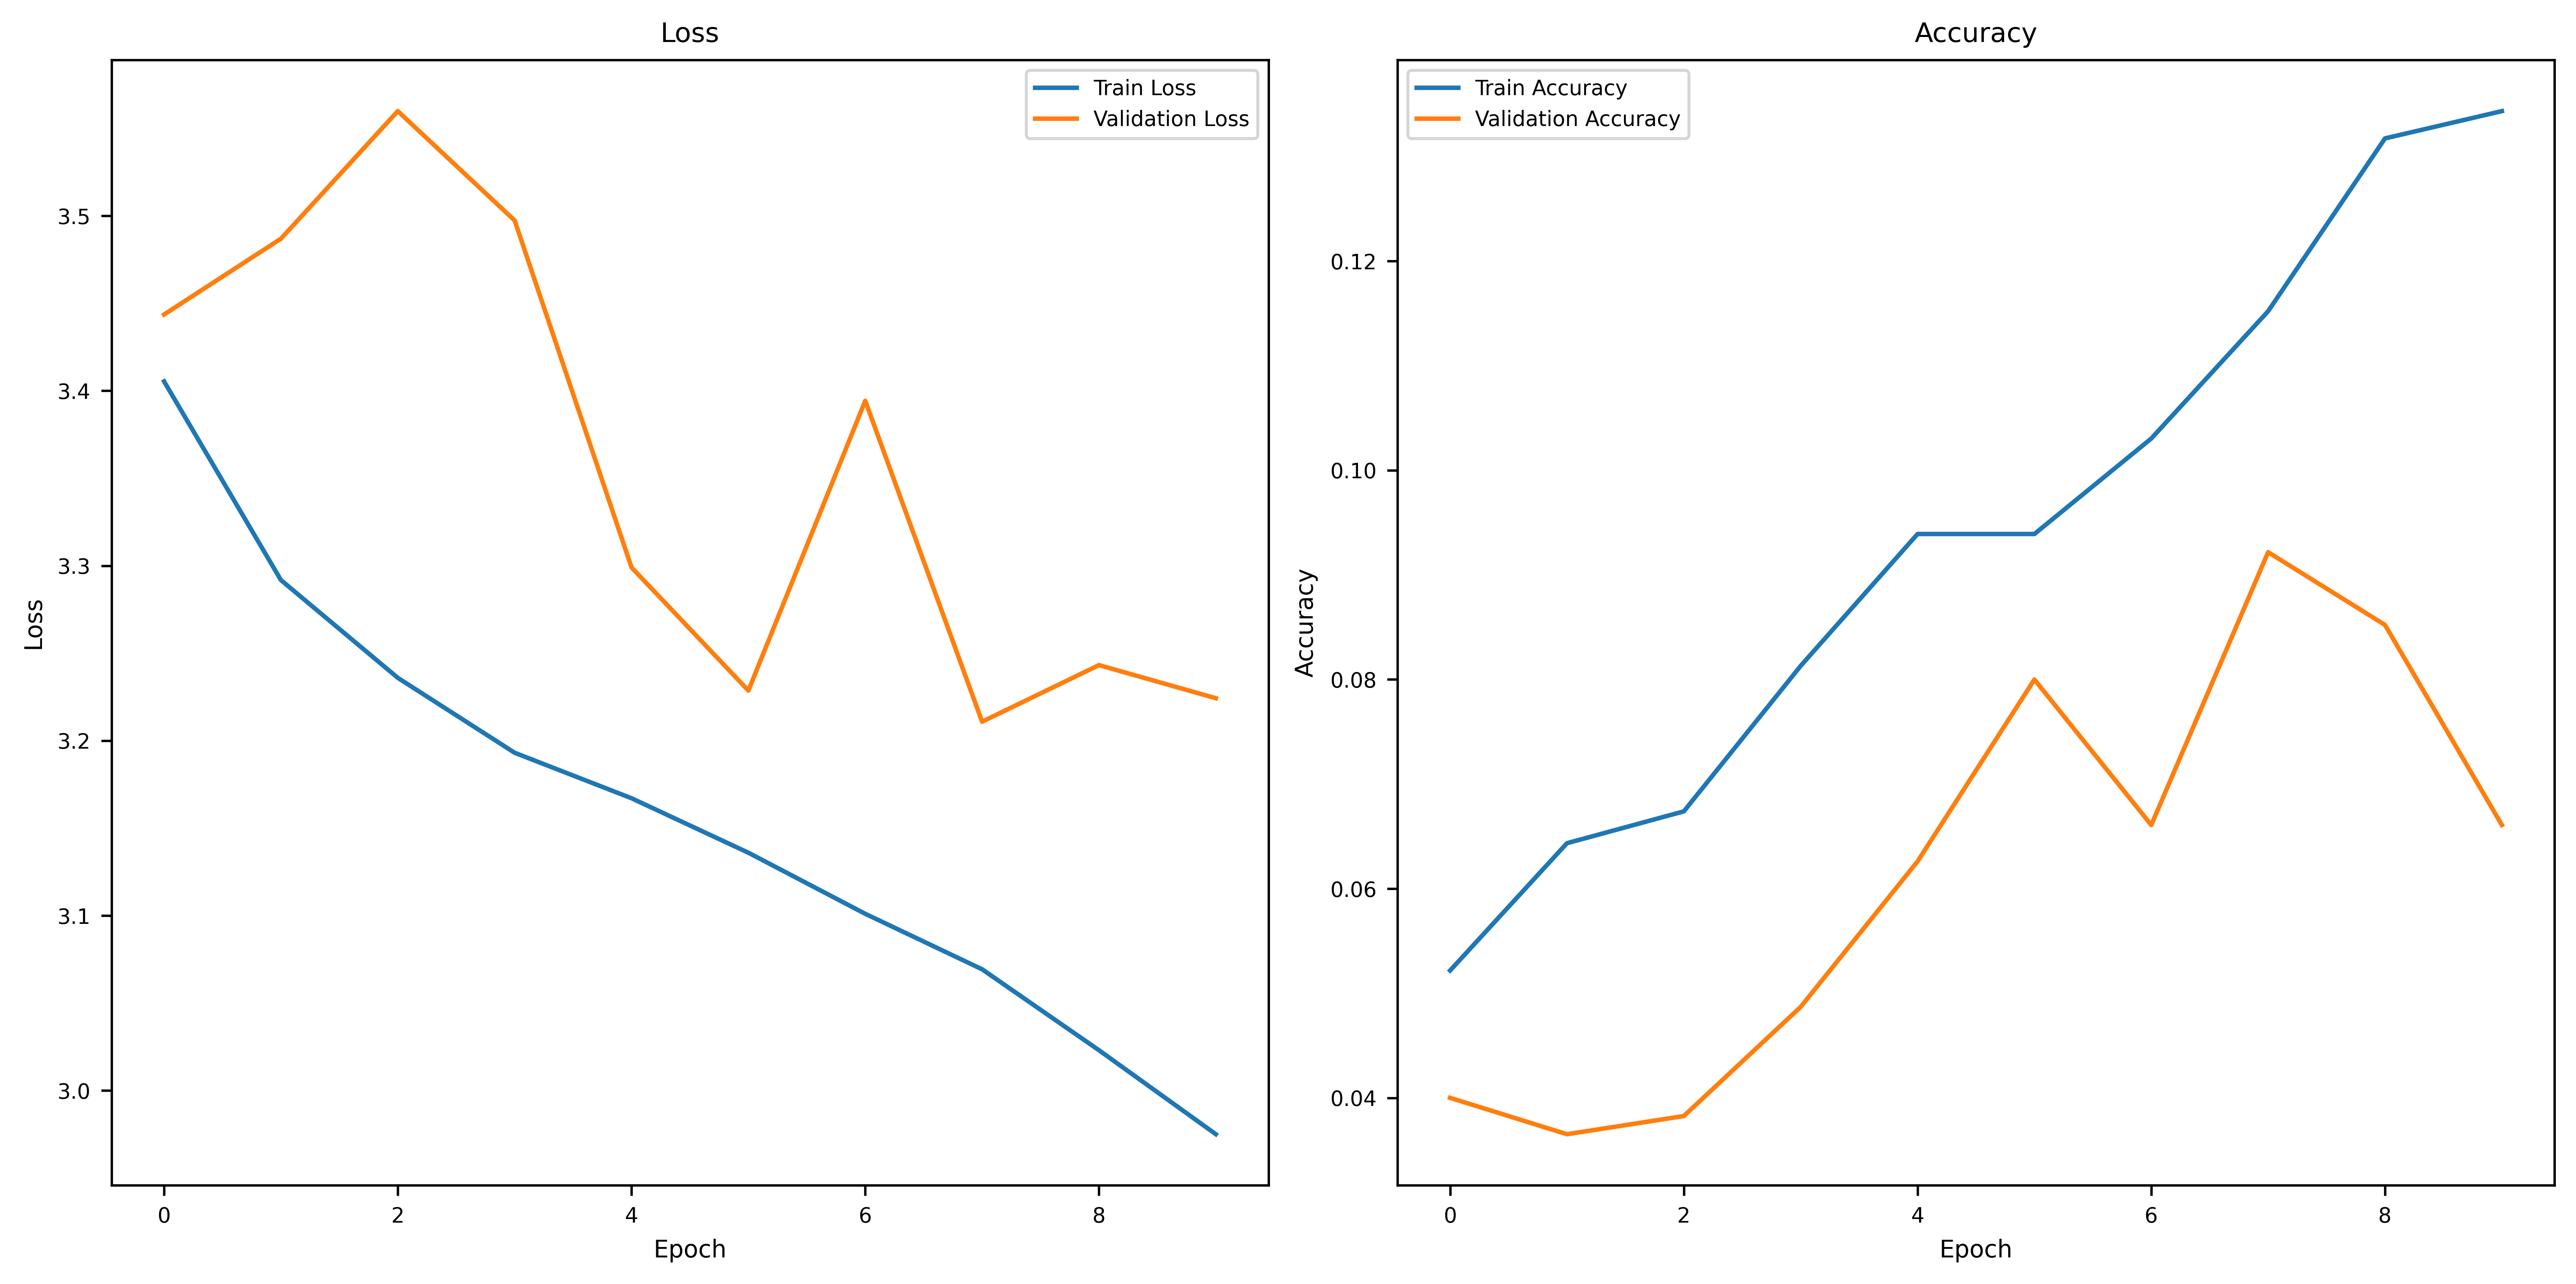

In [94]:
#plot learning curve
import matplotlib.pyplot as plt
import pickle

def plot_learning_curve(history_file):
    with open(history_file, 'rb') as file:
        history_df = pickle.load(file)

    # Plot the learning curve
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history_df['Train Loss'], label='Train Loss')
    plt.plot(history_df['Validation Loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_df['Train Accuracy'], label='Train Accuracy')
    plt.plot(history_df['Validation Accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curve('CRNN_history_class.pkl')

In [ ]:
#train models on biased dataset

# CNN + LSTM
print("Training on biased dataset...")
crnn_model_chord_solver.train_and_evaluate(plot_results=True) #how does the solver use the validation set?

# Save the trained weights
torch.save(crnn_model.state_dict(), "biased_CLSTM_weights.pth")

In [ ]:
#run models on test set and compare results

# Load the trained model
crnn_model.load_state_dict(torch.load("biased_CLSTM_weights.pth"))
crnn_model_chord_solver.run_inference(
    model=crnn_model,
    dataloader=chord_test_loader,
    device=device,
    num_classes=chord_num_classes,
    target_processor=training_data_processor,
    plot_results=True,
)